# One Pixel Attack
This notebook implements a python + pytorch version of the one pixel attack described in https://arxiv.org/abs/1710.08864. After having setup a VGG16 network and verified the classification of sampled images, a pixel candidate will be computer using differential evolution to try to change the classification result of the image.

Let's import pyTorch (refered as torch), its computer vision module "torchivision", as well the differential evolution methods implemented for this demo. The differential evolution method will also use numpy, seaborn and matplotlib.

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
import torch
import torchvision.models as models
from package import DE, vgg_tools
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8,8]
torch.cuda.manual_seed_all

<function torch.cuda.random.manual_seed_all(seed)>

We have a set of test images. The idea is to consider the attack as successful if, for a given key file, the names of the dictionnary entries are not in the classe infered by the neural network. For instance, as long as *"cat"* is in the class description infered for the image *"data/cat.jpg"* (for instance *"tabby cat"*, *"persian cat"* but not *"chihuahua"*), the attack is not successful. 

In [2]:
image_dict = {}
image_dict["data/cat.jpg"] = "cat"
image_dict["data/pizza.jpg"] = "pizza"
image_dict["data/traffic_light.jpg"] = "traffic,light" # this image has not been attacked with success so far
image_dict["data/indian_cobra.jpg"] = "cobra,snake"
image_dict["data/firetruck.jpg"] = "fire,truck"

First, we define the default tensor format as Float. Then an instance of a pretrained VGG16 neural network, using cuda acceleration is created. 

In [3]:
torch.set_default_tensor_type('torch.FloatTensor')
vgg = models.vgg16(pretrained=True).cuda()

Classification of the original images by the model for reference 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

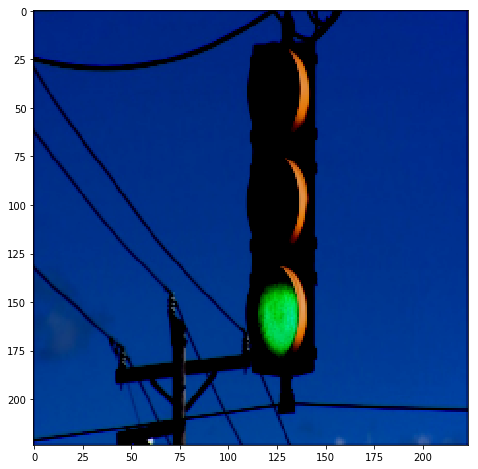

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image : data/traffic_light.jpg, reference results : [['traffic light, traffic signal, stoplight', '0.9543970823287964'], ['spotlight, spot', '0.008738958276808262'], ['tiger beetle', '0.00514673488214612']]


<Figure size 432x288 with 0 Axes>

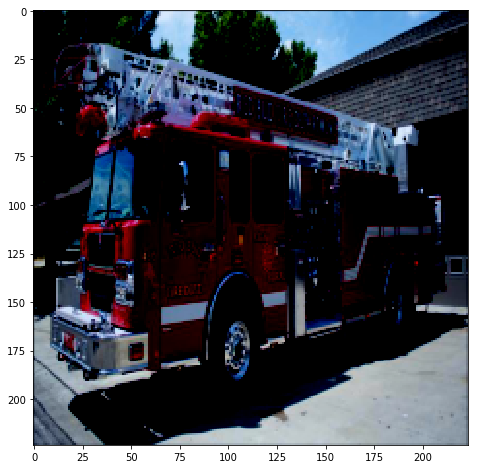

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image : data/firetruck.jpg, reference results : [['fire engine, fire truck', '0.9129751920700073'], ['jeep, landrover', '0.03330418840050697'], ['tow truck, tow car, wrecker', '0.008493170142173767']]


<Figure size 432x288 with 0 Axes>

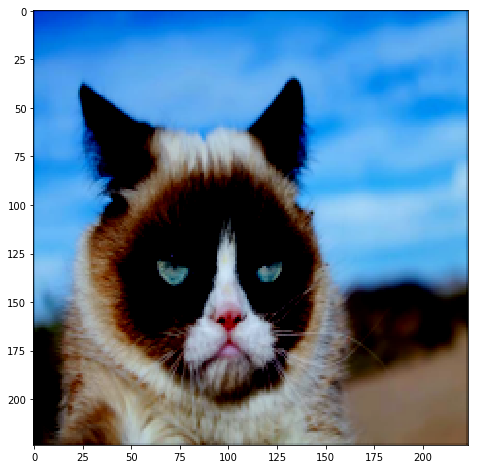

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image : data/cat.jpg, reference results : [['Siamese cat, Siamese', '0.9950022101402283'], ['lynx, catamount', '0.002026930684223771'], ['Egyptian cat', '0.0008398409700021148']]


<Figure size 432x288 with 0 Axes>

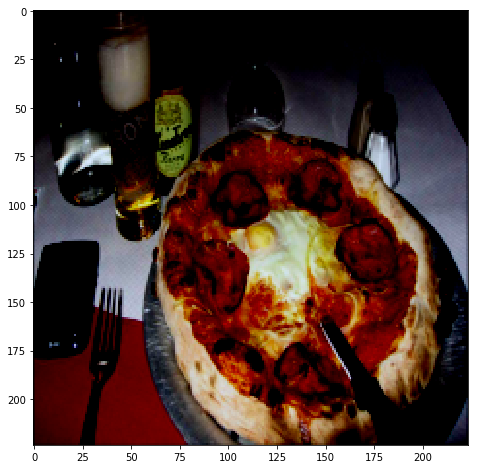

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image : data/pizza.jpg, reference results : [['pizza, pizza pie', '0.9807977080345154'], ['frying pan, frypan, skillet', '0.013752899132668972'], ['spatula', '0.003345098812133074']]


<Figure size 432x288 with 0 Axes>

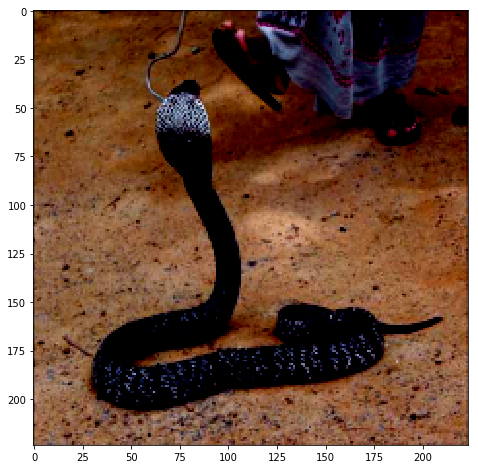

Image : data/indian_cobra.jpg, reference results : [['Indian cobra, Naja naja', '0.7600820660591125'], ['ringneck snake, ring-necked snake, ring snake', '0.1284060776233673'], ['thunder snake, worm snake, Carphophis amoenus', '0.06616891920566559']]


In [4]:
for key in image_dict:
    input_tensor = vgg_tools.image_to_torch_tensor(key)

    reference_results = vgg_tools.extract_top_n_from_output(vgg_tools.generate_model_output(input_tensor, vgg),3)
    reference_image = vgg_tools.tensor_to_image(input_tensor)
    DE.plot_image(input_tensor, image_name = None, save_image=False)

    print("Image : {}, reference results : {}".format(key, reference_results))


Start of differential evolution for an image
+ Description

In [5]:
file = "data/firetruck.jpg"
input_tensor = vgg_tools.image_to_torch_tensor(file)
reference_results = vgg_tools.extract_top_n_from_output(vgg_tools.generate_model_output(input_tensor, vgg), 5)
reference_image = vgg_tools.tensor_to_image(input_tensor)
print("Pixel Attack - Image : {}".format(file))
differential_evolution = DE.differential_evolution(image_name=key, candidate_nb=100,
                                                   image_size_x=224,
                                                   image_size_y=224,
                                                   generation_nb=100,
                                                   reference_image_as_tensor=input_tensor,
                                                   cuda_model=vgg,
                                                   class_keyword=image_dict[file])
differential_evolution.set_initial_NN_results(reference_results)

Pixel Attack - Image : data/firetruck.jpg


We generate a first generation of 100 candidates. These candidates are rgb pixels with random x, y, r, g, b values.
For each candidate we see how the CNN classify the input image after having modified its pixel by the values of the candidate.

In [6]:
differential_evolution.generate_first_candidate_generation()
differential_evolution.evaluate_generation()

We pick the best candidate.
For each candidate, if the image is still classified correctly its score is the difference of confidence score between the reference and modified images.
If the image has been classified incorrectly (the attack is successful), its score is the sum of confidence scores + a bonus of 2.
The image modified by the best candidate is shown below.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Best candidate - classe : fire engine, fire truck, confidence : 0.33, score : 0.19, r : 0.45, g : 1.99, b : 1.85, x : 210, y : 146


<Figure size 432x288 with 0 Axes>

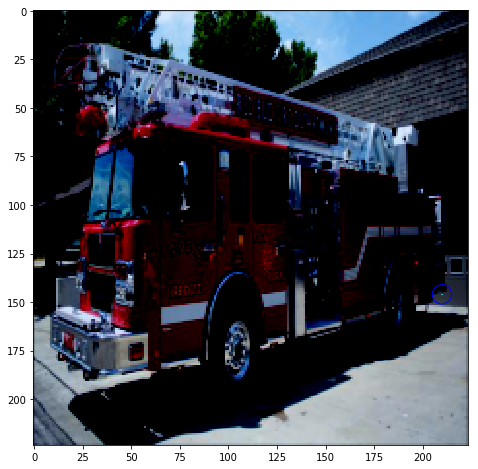

In [7]:
best_candidate = differential_evolution.find_best_candidate()
modified_tensor = DE.change_pixel_of_image(best_candidate.pixel[0], differential_evolution.reference_image_as_tensor)
DE.plot_image_with_pixel_modified(modified_tensor, best_candidate, differential_evolution.image_name, generation=1)


The graphs below show the localisation of candidates (as pixels, then as kernel density plots). The intensity indicates the candidate's score.

<Figure size 432x288 with 0 Axes>

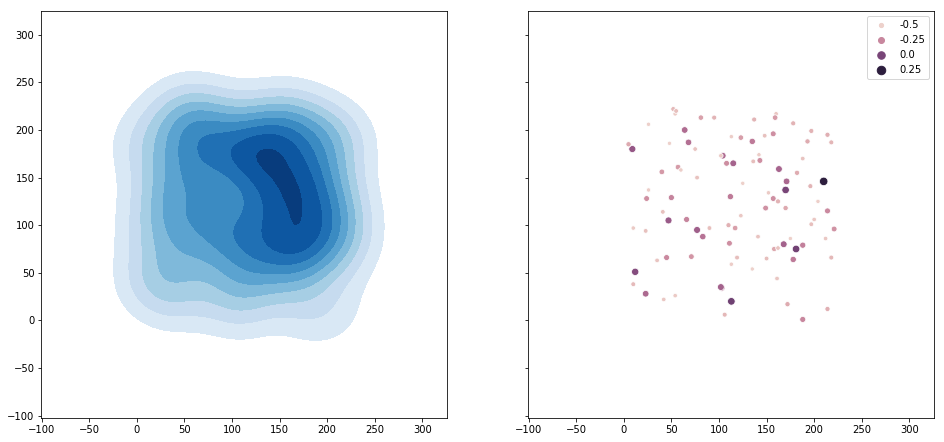

In [8]:
differential_evolution.generate_next_generation()
differential_evolution.plot_candidates_as_kde(1)

Let's iterate on 20 generations with plots each 5 generations. If the attack is successful, we stop. 

DE - Génération 0
Best candidate - classe : fire engine, fire truck, confidence : 0.23, score : 0.28, r : 1.42, g : 1.20, b : 1.83, x : 116, y : 130


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

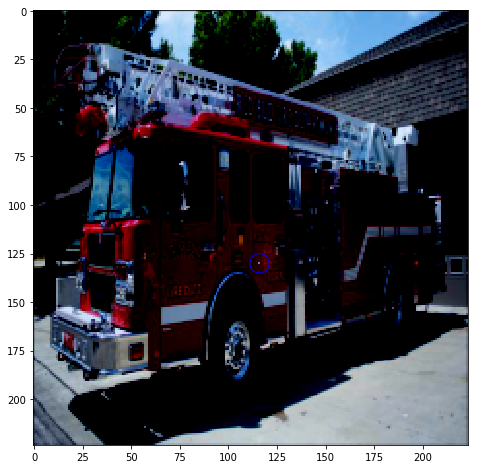

<Figure size 432x288 with 0 Axes>

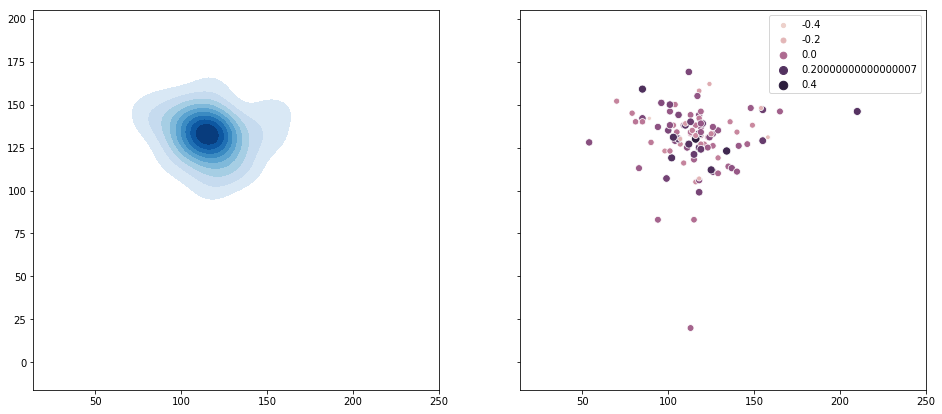

DE - Génération 1
Best candidate - classe : fire engine, fire truck, confidence : 0.23, score : 0.28, r : 1.42, g : 1.20, b : 1.83, x : 116, y : 130
DE - Génération 2
Best candidate - classe : container ship, containership, container vessel, confidence : 0.35, score : 1.87, r : 1.42, g : 1.50, b : 1.49, x : 107, y : 137


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

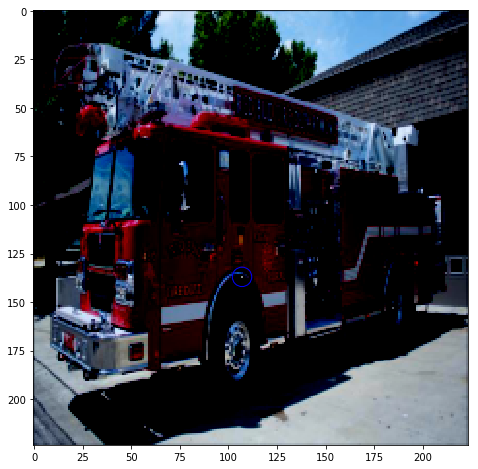

<Figure size 432x288 with 0 Axes>

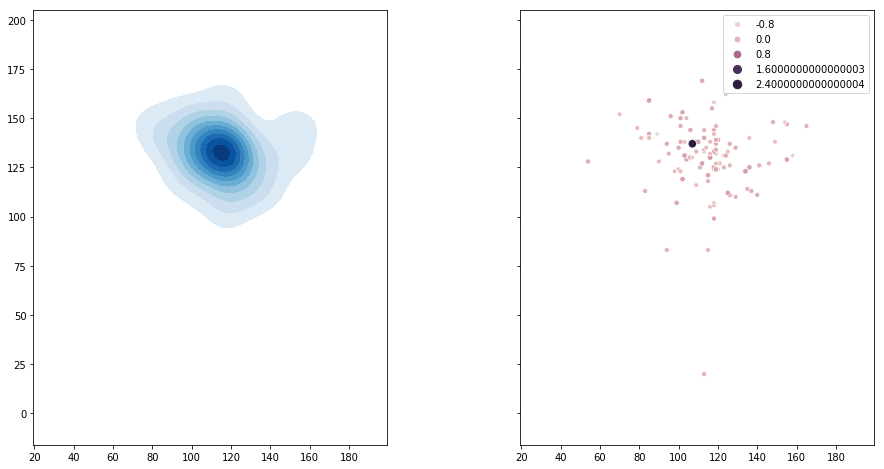

Attack successful !


In [10]:
 for generation in range(20):
            print("DE - Génération {}".format(generation))
            differential_evolution.evaluate_generation()
            best_candidate = differential_evolution.find_best_candidate()
            modified_tensor = DE.change_pixel_of_image(best_candidate.pixel[0], differential_evolution.reference_image_as_tensor)
            differential_evolution.generate_next_generation()
            if generation % 5 == 0:
                DE.plot_image_with_pixel_modified(modified_tensor, best_candidate, differential_evolution.image_name, generation)
                differential_evolution.plot_candidates_as_kde(generation)
            if (differential_evolution.attack_successful):
                DE.plot_image_with_pixel_modified(modified_tensor, best_candidate, differential_evolution.image_name, generation)
                differential_evolution.plot_candidates_as_kde(generation)
                print("Attack successful !")
                break

Illustrating the activation of the CNN before and after attack